In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

2026-01-06 16:14:50.591698: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-06 16:14:50.596958: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-06 16:14:50.779401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-06 16:14:51.884482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [4]:
import tensorflow as tf
import os

BASE_DIR = "plantvillage dataset"
TYPES = ['color', 'grayscale', 'segmented']
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SEED = 123

data_collections = {}

for name in TYPES:
    print(f"Loading data for: {name}")
    source_path = os.path.join(BASE_DIR, name)

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        source_path,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode="rgb"
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        source_path,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode="rgb"
    )

    class_names = train_ds.class_names

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

    data_collections[name] = {
        "train": train_ds,
        "val": val_ds,
        "classes": class_names
    }


Loading data for: color
Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Loading data for: grayscale
Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Loading data for: segmented
Found 54306 files belonging to 38 classes.
Using 43445 files for training.
Found 54306 files belonging to 38 classes.
Using 10861 files for validation.


In [5]:
normalization = layers.Rescaling(1./255)

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization(x), y))

In [6]:
cnn_model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


/home/nishkarsh/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,912,294 (91.22 MB)

 Trainable params: 23,912,294 (91.22 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history_cnn = cnn_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=3
)

Epoch 1/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 536s 99ms/step - accuracy: 0.5591 - loss: 1.5345 - val_accuracy: 0.7031 - val_loss: 1.0175
Epoch 2/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 609s 112ms/step - accuracy: 0.7527 - loss: 0.8122 - val_accuracy: 0.7785 - val_loss: 0.7403
Epoch 3/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 567s 104ms/step - accuracy: 0.8004 - loss: 0.6372 - val_accuracy: 0.7520 - val_loss: 0.8960


In [8]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax')
])

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

tl_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
history_tl = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 350s 64ms/step - accuracy: 0.8565 - loss: 0.4677 - val_accuracy: 0.9023 - val_loss: 0.3014
Epoch 2/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 358s 66ms/step - accuracy: 0.9062 - loss: 0.2797 - val_accuracy: 0.9103 - val_loss: 0.2656
Epoch 3/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 354s 65ms/step - accuracy: 0.9206 - loss: 0.2372 - val_accuracy: 0.9119 - val_loss: 0.2614


In [12]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 391s 71ms/step - accuracy: 0.8369 - loss: 0.5727 - val_accuracy: 0.9244 - val_loss: 0.2231
Epoch 2/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 383s 71ms/step - accuracy: 0.9050 - loss: 0.2889 - val_accuracy: 0.9406 - val_loss: 0.1792
Epoch 3/3
5431/5431 ━━━━━━━━━━━━━━━━━━━━ 375s 69ms/step - accuracy: 0.9257 - loss: 0.2210 - val_accuracy: 0.9535 - val_loss: 0.1429


In [13]:
cnn_acc = cnn_model.evaluate(val_ds)[1]
tl_acc = tl_model.evaluate(val_ds)[1]

print("CNN Accuracy:", cnn_acc)
print("Transfer Learning Accuracy:", tl_acc)


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.7520 - loss: 0.8960
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.9535 - loss: 0.1429
CNN Accuracy: 0.7520486116409302
Transfer Learning Accuracy: 0.9535033702850342


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━

2026-01-06 21:01:05.760505: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


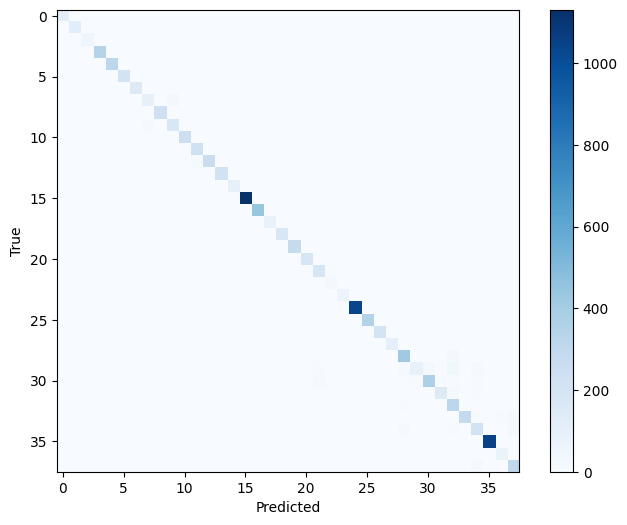

In [14]:
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = tl_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


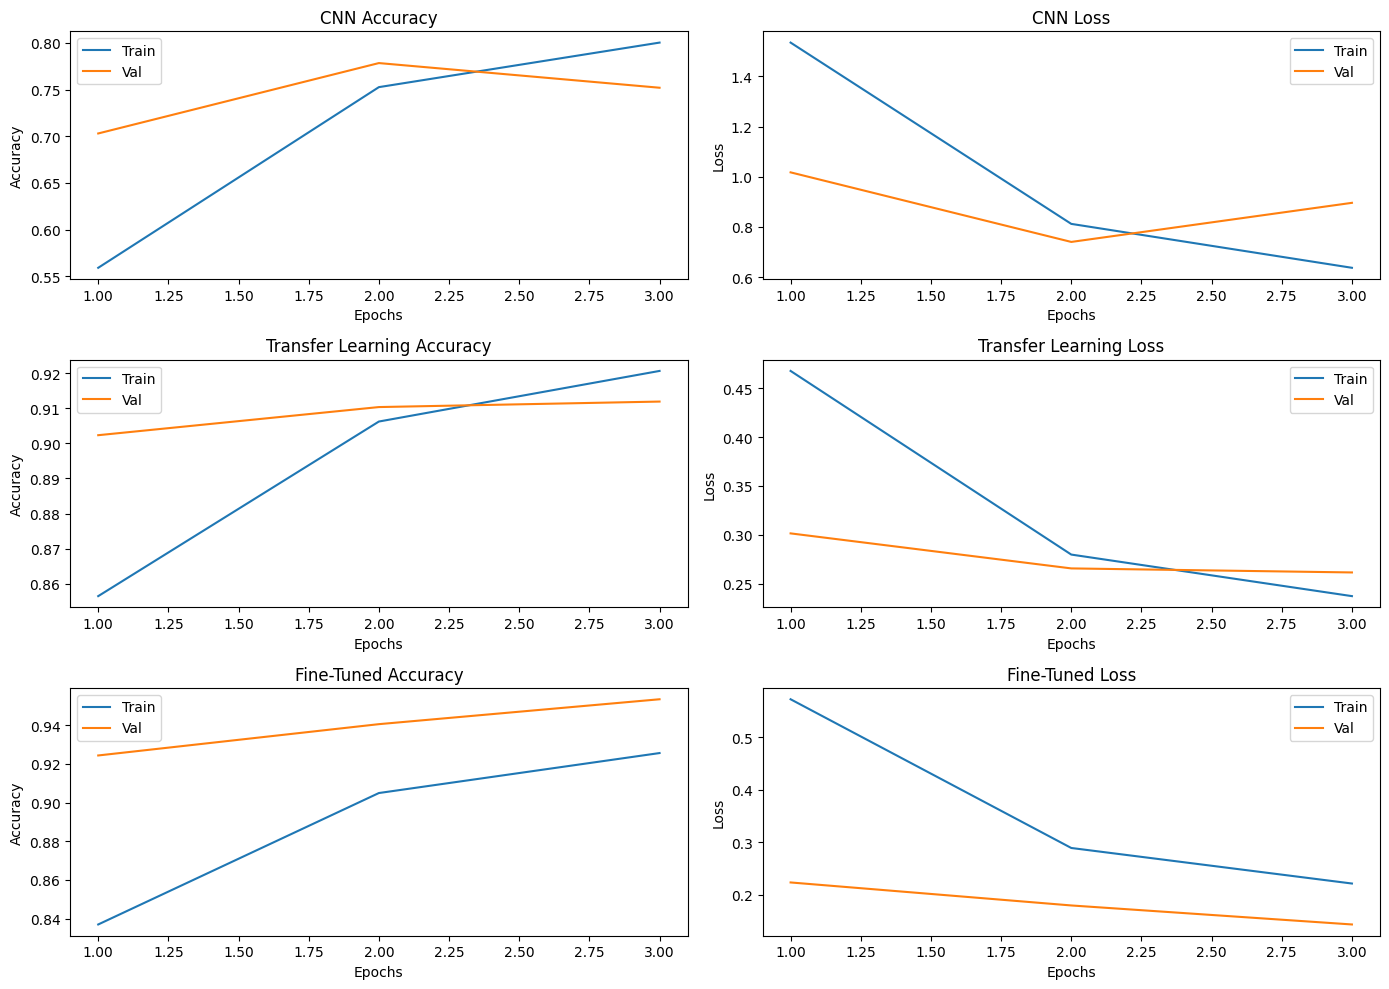

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))

# ================= CNN =================
epochs_cnn = range(1, len(history_cnn.history['accuracy']) + 1)

plt.subplot(3,2,1)
plt.plot(epochs_cnn, history_cnn.history['accuracy'], label='Train')
plt.plot(epochs_cnn, history_cnn.history['val_accuracy'], label='Val')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,2,2)
plt.plot(epochs_cnn, history_cnn.history['loss'], label='Train')
plt.plot(epochs_cnn, history_cnn.history['val_loss'], label='Val')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# ========== TRANSFER LEARNING (Frozen) ==========
epochs_tl = range(1, len(history_tl.history['accuracy']) + 1)

plt.subplot(3,2,3)
plt.plot(epochs_tl, history_tl.history['accuracy'], label='Train')
plt.plot(epochs_tl, history_tl.history['val_accuracy'], label='Val')
plt.title('Transfer Learning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,2,4)
plt.plot(epochs_tl, history_tl.history['loss'], label='Train')
plt.plot(epochs_tl, history_tl.history['val_loss'], label='Val')
plt.title('Transfer Learning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# ========== FINE TUNING ==========
epochs_ft = range(1, len(history_ft.history['accuracy']) + 1)

plt.subplot(3,2,5)
plt.plot(epochs_ft, history_ft.history['accuracy'], label='Train')
plt.plot(epochs_ft, history_ft.history['val_accuracy'], label='Val')
plt.title('Fine-Tuned Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,2,6)
plt.plot(epochs_ft, history_ft.history['loss'], label='Train')
plt.plot(epochs_ft, history_ft.history['val_loss'], label='Val')
plt.title('Fine-Tuned Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
